# <font color="red">**INFLATION FORECAST: Weekly estimates**</font>

**Author:** Osmar Bolivar

In [ ]:
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objects as go

Mounted at /content/drive


## **1. Data**

### **1.1. Monthly**

In [2]:
ipc_series = pd.read_excel('/content/drive/MyDrive/Research/CEMLA 2024/IPC_monthly.xlsx', index_col=0)
dataset = pd.read_excel('/content/drive/MyDrive/Research/CEMLA 2024/DATASET.xlsx', index_col=0)
dataset['exchange'] = 1/dataset['exchange']  ## to ensure a positive correlation
dataset_m = dataset.dropna(subset=['ipc_nal'])
dataset_m = dataset_m.drop(['week_set'], axis=1)

dataset_m.drop(['ipc_food', 'ipc_nofood', 'ipc_ali'], axis=1, inplace=True)
dataset_m = dataset_m.assign(ipc_nal_l1 = dataset_m['ipc_nal'].shift(1),
                 ipc_nal_l2 = dataset_m['ipc_nal'].shift(2),
                 ipc_nal_l3 = dataset_m['ipc_nal'].shift(3),
                 ipc_nal_l6 = dataset_m['ipc_nal'].shift(6),
                 ipc_nal_l9 = dataset_m['ipc_nal'].shift(9),
                 ipc_nal_l12 = dataset_m['ipc_nal'].shift(12))

dataset_m.loc['2011-01-31':'2011-01-31', 'ipc_nal_l1'] = ipc_series.loc['2010-12-01':'2010-12-01', 'ipc_nal'].values
dataset_m.loc['2011-01-31':'2011-02-28', 'ipc_nal_l2'] = ipc_series.loc['2010-11-01':'2010-12-01', 'ipc_nal'].values
dataset_m.loc['2011-01-31':'2011-03-31', 'ipc_nal_l3'] = ipc_series.loc['2010-10-01':'2010-12-01', 'ipc_nal'].values
dataset_m.loc['2011-01-31':'2011-06-30', 'ipc_nal_l6'] = ipc_series.loc['2010-07-01':'2010-12-01', 'ipc_nal'].values
dataset_m.loc['2011-01-31':'2011-09-30', 'ipc_nal_l9'] = ipc_series.loc['2010-04-01':'2010-12-01', 'ipc_nal'].values
dataset_m.loc['2011-01-31':'2011-12-31', 'ipc_nal_l12'] = ipc_series.loc['2010-01-01':'2010-12-01', 'ipc_nal'].values

In [3]:
ldf_corr = dataset_m.copy()
ldf_corr = ldf_corr.dropna(axis = 1)
df = ldf_corr.copy()

predictors1 = ['ipc_nal', 'ipc_nal_l1', 'ipc_nal_l2', 'ipc_nal_l3', 'ipc_nal_l6', 'ipc_nal_l12',
               'ufv', 'exchange', 'libor', 'zinc',
               'Precio - Tema', 'Interés - Tema', 'dinero', 'Dinero - Tema', 'Política - Tema', 'la inflación', 'Inflación', 'Inflación - Tema', 'que es inflación', 'Salario - Tema',
               'milk_lp', 'milk_dlp', 'milk_or', 'milk_bol', 'paprika_tr', 'milk_sc', 'rice3_ea_y', 'rice3_ea_x', 'beef_dlp',
               'beef_lp', 'milk_po', 'milk_su', 'squash_tr', 'milk_cb', 'banana_co', 'banana_ea', 'pineapple_ea', 'beef_bol', 'corn_co', 'milk2_or',
               'milk2_po', 'ycorn_ea', 'papaya_tr', 'milk_ea', 'wheat_sc', 'apple_sc', 'beef_su', 'sorghum_lp', 'onion2_po', 'rice_ea', 'banana_bol', 'redpepper_tr',
               'sorghum_bol', 'banana_tj', 'flour_tj', 'platano_ea', 'milk2_dlp', 'beef_or', 'flour_po', 'sorghum_dlp', 'grapefruit_po', 'beef_sc', 'bean_tr', 'corn_ea',
               'rice2_co', 'apple_or', 'flour2_ea', 'banana_tr', 'beef_cb', 'milk2_lp', 'greenbean_tr', 'banana_sc', 'peas_tr', 'apple_bol', 'grapefruit_cb',
               'pineapple_or', 'wheat_bol', 'redpepper_po', 'peas_ea', 'papa1_ea', 'banana_su', 'lemon_cb', 'rice2_or', 'banana_lp', 'quinoa_ea', 'oil_co', 'beef_tr']

df = df[predictors1]

In [4]:
#df.to_excel('/content/drive/MyDrive/Research/CEMLA 2024/FULLSET_IPC_FEATURES.xlsx')

### **1.2. Weekly**

In [5]:
dataset_w = dataset['2018-01-31':].copy()
dataset_w.drop(['week_set', 'ipc_food', 'ipc_nofood', 'ipc_ali'], axis=1, inplace=True)

month_lags = dataset_m.loc[:, 'ipc_nal_l1':].copy()
dataset_w = dataset_w.merge(month_lags, left_index=True, right_index=True, how='left')
dataset_w.loc[:, 'ipc_nal':'ipc_nal_l12'] = dataset_w.loc[:, 'ipc_nal':'ipc_nal_l12'].fillna(method='bfill')

In [6]:
test = dataset_w.loc['2019-01-06':, predictors1].copy()

## **2. Train and Val sets**

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
train, validation = train_test_split(df, test_size=0.2, random_state=42)
print(f'Obs in train set: {train.shape[0]}; variables in train set: {train.shape[1]}')
print(f'Obs in validation set: {validation.shape[0]}; variables in validation set: {validation.shape[1]}')

Obs in train set: 124; variables in train set: 87
Obs in validation set: 32; variables in validation set: 87


In [9]:
scaler = StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)
validation_scaled = pd.DataFrame(scaler.transform(validation), columns=validation.columns, index=validation.index)
test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)

X_train = train_scaled.drop('ipc_nal', axis=1)
y_train = train_scaled['ipc_nal']

X_validation = validation_scaled.drop('ipc_nal', axis=1)
y_validation = validation_scaled['ipc_nal']

X_test = test_scaled.drop('ipc_nal', axis=1)
y_test = test_scaled['ipc_nal']

## **3. Algorithms**

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

### **3.1. Ridge**
Without tuning:
Validation MSE:  0.001453348422371209
Validation R2:  0.9984692589865253
Validation MAE:  0.030880852442606015

In [11]:
#ridge = Ridge()
ridge = Ridge(alpha=0.11326825671361537, fit_intercept=False, positive=True, random_state=0)  ## cv=5
# Fit on training set
ridge.fit(X_train, y_train)
# Make predictions on validation set using best model from GridSearchCV
ridge_train_pred = ridge.predict(X_train)
ridge_val_pred = ridge.predict(X_validation)
# Calculate Forecast metrics on train set
mse_train_ridge = mean_squared_error(y_train, ridge_train_pred, squared=True)
r2_train_ridge = r2_score(y_train, ridge_train_pred)
mae_train_ridge = mean_absolute_error(y_train, ridge_train_pred)
print("Train MSE: ", mse_train_ridge)
print("Train R2: ", r2_train_ridge)
print("Train MAE: ", mae_train_ridge)
# Calculate Forecast metrics on validation set
mse_val_ridge = mean_squared_error(y_validation, ridge_val_pred, squared=True)
r2_val_ridge = r2_score(y_validation, ridge_val_pred)
mae_val_ridge = mean_absolute_error(y_validation, ridge_val_pred)
print("Validation MSE: ", mse_val_ridge)
print("Validation R2: ", r2_val_ridge)
print("Validation MAE: ", mae_val_ridge)

ridge_test_pred = ridge.predict(X_test)

Train MSE:  0.0009685506142816655
Train R2:  0.9990314493857183
Train MAE:  0.023990799980695445
Validation MSE:  0.0008789962503193361
Validation R2:  0.9990741961181896
Validation MAE:  0.024689020488252875


In [12]:
# Get the coefficients from the Ridge model
coef = ridge.coef_
# Create a dataframe of feature importances
feature_importance_ridge = pd.DataFrame({'Feature': X_train.columns, 'Importance': coef})
# Sort the features by importance
feature_importance_ridge = feature_importance_ridge.sort_values('Importance', ascending=False).reset_index(drop=True)
feature_importance_ridge.columns = ['feat', 'imp_ridge']
# Print the feature importances
feature_importance_ridge.head(15)

,feat,imp_ridge
0,ipc_nal_l1,0.176189
1,ipc_nal_l2,0.143652
2,ufv,0.117003
3,ipc_nal_l3,0.116663
4,ipc_nal_l6,0.114626
5,ipc_nal_l12,0.105408
6,rice2_or,0.030389
7,Precio - Tema,0.024705
8,greenbean_tr,0.019965
9,milk_po,0.019031


### **3.2. Lasso**
Without tuning:
Validation MSE:  0.9523622169433499
Validation R2:  -0.0030766763969758415
Validation MAE:  0.8455503308136401

In [13]:
#lasso = Lasso()
lasso = Lasso(alpha=0.1, fit_intercept=False, positive=True, random_state=0)  ## cv=5
# Fit on training set
lasso.fit(X_train, y_train)
# Make predictions on validation set using best model from GridSearchCV
lasso_train_pred = lasso.predict(X_train)
lasso_val_pred = lasso.predict(X_validation)
# Calculate Forecast metrics on train set
mse_train_lasso = mean_squared_error(y_train, lasso_train_pred, squared=True)
r2_train_lasso = r2_score(y_train, lasso_train_pred)
mae_train_lasso = mean_absolute_error(y_train, lasso_train_pred)
print("Train MSE: ", mse_train_lasso)
print("Train R2: ", r2_train_lasso)
print("Train MAE: ", mae_train_lasso)
# Calculate Forecast metrics on validation set
mse_val_lasso = mean_squared_error(y_validation, lasso_val_pred, squared=True)
r2_val_lasso = r2_score(y_validation, lasso_val_pred)
mae_val_lasso = mean_absolute_error(y_validation, lasso_val_pred)
print("Validation MSE: ", mse_val_lasso)
print("Validation R2: ", r2_val_lasso)
print("Validation MAE: ", mae_val_lasso)

lasso_test_pred = lasso.predict(X_test)

Train MSE:  0.01135096248401723
Train R2:  0.9886490375159828
Train MAE:  0.0886406245973438
Validation MSE:  0.009937567975745763
Validation R2:  0.9895332443063803
Validation MAE:  0.08505641169339459


In [14]:
# Get the coefficients from the Lasso model
coef = lasso.coef_
# Create a dataframe of feature importances
feature_importance_lasso = pd.DataFrame({'Feature': X_train.columns, 'Importance': coef})
# Sort the features by importance
feature_importance_lasso = feature_importance_lasso.sort_values('Importance', ascending=False).reset_index(drop=True)
feature_importance_lasso.columns = ['feat', 'imp_lasso']
# Print the feature importances
feature_importance_lasso.head(15)

,feat,imp_lasso
0,ipc_nal_l1,0.899295
1,ipc_nal_l6,0.000053
2,milk2_dlp,0.000000
3,rice2_co,0.000000
4,corn_ea,0.000000
5,bean_tr,0.000000
6,beef_sc,0.000000
7,grapefruit_po,0.000000
8,sorghum_dlp,0.000000
9,flour_po,0.000000


### **3.3. ElasticNet**
Without tuning:
Validation MSE:  0.2878895501474107
Validation R2:  0.6967799772043428
Validation MAE:  0.4602160948451647

In [15]:
#enet = ElasticNet()
enet = ElasticNet(alpha=0.11326825671361537, l1_ratio=0.1, fit_intercept=False, positive=True, random_state=0)  ## cv=5
# Fit on training set
enet.fit(X_train, y_train)
# Make predictions on validation set using best model from GridSearchCV
enet_train_pred = enet.predict(X_train)
enet_val_pred = enet.predict(X_validation)
# Calculate Forecast metrics on train set
mse_train_enet = mean_squared_error(y_train, enet_train_pred, squared=True)
r2_train_enet = r2_score(y_train, enet_train_pred)
mae_train_enet = mean_absolute_error(y_train, enet_train_pred)
print("Train MSE: ", mse_train_enet)
print("Train R2: ", r2_train_enet)
print("Train MAE: ", mae_train_enet)
# Calculate Forecast metrics on validation set
mse_val_enet = mean_squared_error(y_validation, enet_val_pred, squared=True)
r2_val_enet = r2_score(y_validation, enet_val_pred)
mae_val_enet = mean_absolute_error(y_validation, enet_val_pred)
print("Validation MSE: ", mse_val_enet)
print("Validation R2: ", r2_val_enet)
print("Validation MAE: ", mae_val_enet)

enet_test_pred = enet.predict(X_test)

Train MSE:  0.00229930060486275
Train R2:  0.9977006993951373
Train MAE:  0.037499497739494195
Validation MSE:  0.002184761201136335
Validation R2:  0.9976988975776564
Validation MAE:  0.03613732499724336


In [16]:
# Get the coefficients from the enet model
coef = enet.coef_
# Create a dataframe of feature importances
feature_importance_enet = pd.DataFrame({'Feature': X_train.columns, 'Importance': coef})
# Sort the features by importance
feature_importance_enet = feature_importance_enet.sort_values('Importance', ascending=False).reset_index(drop=True)
feature_importance_enet.columns = ['feat', 'imp_enet']
# Print the feature importances
feature_importance_enet.head(15)

,feat,imp_enet
0,ipc_nal_l1,0.085091
1,ipc_nal_l2,0.082577
2,ipc_nal_l3,0.080204
3,ufv,0.078308
4,ipc_nal_l6,0.077875
5,ipc_nal_l12,0.074727
6,paprika_tr,0.037677
7,rice2_or,0.033056
8,Precio - Tema,0.032971
9,beef_dlp,0.024672


### **3.4. ADA**
Without tuning:
Validation MSE:  0.0036814337026600556
Validation R2:  0.9961225254245258
Validation MAE:  0.0469554086526466

In [17]:
#ada = AdaBoostRegressor()
ada = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=5), n_estimators=115, learning_rate=1.235482888256747, random_state=0)
# Fit the model on training data
ada.fit(X_train, y_train)
# Make predictions on the validation set
ada_train_pred = ada.predict(X_train)
ada_val_pred = ada.predict(X_validation)
# Calculate Forecast metrics on train set
mse_train_ada = mean_squared_error(y_train, ada_train_pred, squared=True)
r2_train_ada = r2_score(y_train, ada_train_pred)
mae_train_ada = mean_absolute_error(y_train, ada_train_pred)
print("Train MSE: ", mse_train_ada)
print("Train R2: ", r2_train_ada)
print("Train MAE: ", mae_train_ada)
# Evaluate the model on the validation set
mse_val_ada = mean_squared_error(y_validation, ada_val_pred, squared=True)
r2_val_ada = r2_score(y_validation, ada_val_pred)
mae_val_ada = mean_absolute_error(y_validation, ada_val_pred)
print("Validation MSE: ", mse_val_ada)
print("Validation R2: ", r2_val_ada)
print("Validation MAE: ", mae_val_ada)

ada_test_pred = ada.predict(X_test)

Train MSE:  0.00018819514548264988
Train R2:  0.9998118048545174
Train MAE:  0.008874656515510271
Validation MSE:  0.0015359744788909161
Validation R2:  0.9983822329908661
Validation MAE:  0.030830800759530264


In [18]:
# Create a DataFrame with the feature importance values
feature_importance_ada = pd.DataFrame({'Feature': X_train.columns, 'Importance': ada.feature_importances_})
# Sort the DataFrame by importance values in descending order
feature_importance_ada = feature_importance_ada.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_ada.columns = ['feat', 'imp_ada']
# Print the feature importance DataFrame
feature_importance_ada.head(15)

,feat,imp_ada
0,ipc_nal_l12,0.083600
1,ipc_nal_l1,0.069771
2,ipc_nal_l6,0.065241
3,ufv,0.061322
4,ipc_nal_l2,0.054186
5,milk2_po,0.054050
6,milk_bol,0.044811
7,ipc_nal_l3,0.042878
8,ycorn_ea,0.041061
9,milk_or,0.038410


### **3.5. GBR**
Without tuning:
Validation MSE:  0.0014618738110729937
Validation R2:  0.998460279610389
Validation MAE:  0.02910552415848012

In [19]:
#gbr = GradientBoostingRegressor(random_state=0)
gbr = GradientBoostingRegressor(learning_rate=0.040949150623804255, n_estimators=290, random_state=0)
# Fit the model on the training set
gbr.fit(X_train, y_train)
# Make predictions on validation set using best model from GridSearchCV
gbr_train_pred = gbr.predict(X_train)
gbr_val_pred = gbr.predict(X_validation)
# Calculate Forecast metrics on train set
mse_train_gbr = mean_squared_error(y_train, gbr_train_pred, squared=True)
r2_train_gbr = r2_score(y_train, gbr_train_pred)
mae_train_gbr = mean_absolute_error(y_train, gbr_train_pred)
print("Train MSE: ", mse_train_gbr)
print("Train R2: ", r2_train_gbr)
print("Train MAE: ", mae_train_gbr)
# Calculate Forecast metrics on validation set
mse_val_gbr = mean_squared_error(y_validation, gbr_val_pred, squared=True)
r2_val_gbr = r2_score(y_validation, gbr_val_pred)
mae_val_gbr = mean_absolute_error(y_validation, gbr_val_pred)
print("Validation MSE: ", mse_val_gbr)
print("Validation R2: ", r2_val_gbr)
print("Validation MAE: ", mae_val_gbr)

gbr_test_pred = gbr.predict(X_test)

Train MSE:  2.0138008992389104e-06
Train R2:  0.9999979861991007
Train MAE:  0.0010714078864243416
Validation MSE:  0.0009358846602942081
Validation R2:  0.999014278330411
Validation MAE:  0.02423397088317967


In [20]:
# Create a DataFrame with the feature importance values
feature_importance_gbr = pd.DataFrame({'Feature': X_train.columns, 'Importance': gbr.feature_importances_})
# Sort the DataFrame by importance values in descending order
feature_importance_gbr = feature_importance_gbr.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_gbr.columns = ['feat', 'imp_gbr']
# Print the feature importance DataFrame
feature_importance_gbr.head(15)

,feat,imp_gbr
0,ipc_nal_l1,0.244348
1,ufv,0.163475
2,ipc_nal_l6,0.129661
3,ipc_nal_l2,0.103521
4,flour_tj,0.099769
5,ipc_nal_l12,0.073505
6,ipc_nal_l3,0.057125
7,ycorn_ea,0.045724
8,milk_bol,0.010039
9,rice_ea,0.009505


### **3.4. RF**

Before tuning:
Validation MSE:  0.0011726920640594718
Validation R2:  0.9987648606411232
Validation MAE:  0.02773685193083499

In [21]:
# Define the Random Forest Regression model
#rf = RandomForestRegressor(random_state=0)
rf = RandomForestRegressor(min_samples_split=2, n_estimators=265, random_state=0)

# Fit the model to the training data and make predictions on the validation set
rf.fit(X_train, y_train)
# Make predictions on validation set using best model from GridSearchCV
rf_train_pred = rf.predict(X_train)
rf_val_pred = rf.predict(X_validation)
# Calculate Forecast metrics on train set
mse_train_rf = mean_squared_error(y_train, rf_train_pred, squared=True)
r2_train_rf = r2_score(y_train, rf_train_pred)
mae_train_rf = mean_absolute_error(y_train, rf_train_pred)
print("Train MSE: ", mse_train_rf)
print("Train R2: ", r2_train_rf)
print("Train MAE: ", mae_train_rf)
# Calculate Forecast metrics on validation set
mse_val_rf = mean_squared_error(y_validation, rf_val_pred, squared=True)
r2_val_rf = r2_score(y_validation, rf_val_pred)
mae_val_rf = mean_absolute_error(y_validation, rf_val_pred)
print("Validation MSE: ", mse_val_rf)
print("Validation R2: ", r2_val_rf)
print("Validation MAE: ", mae_val_rf)

rf_test_pred = rf.predict(X_test)

Train MSE:  0.0003517500886979855
Train R2:  0.999648249911302
Train MAE:  0.012542657697006365
Validation MSE:  0.0009293079236961767
Validation R2:  0.9990212052863223
Validation MAE:  0.025707540837993953


In [22]:
# Create a DataFrame with the feature importance values
feature_importance_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
# Sort the DataFrame by importance values in descending order
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_rf.columns = ['feat', 'imp_rf']
# Print the feature importance DataFrame
feature_importance_rf.head(30)

,feat,imp_rf
0,ipc_nal_l2,0.140342
1,ufv,0.128274
2,ipc_nal_l1,0.122598
3,ipc_nal_l3,0.096306
4,ipc_nal_l6,0.085552
5,flour_tj,0.083533
6,ipc_nal_l12,0.075440
7,ycorn_ea,0.061164
8,milk2_po,0.021154
9,milk2_dlp,0.015461


### **3.5. ET**

In [23]:
# Define the Extra Trees Regression model
et = ExtraTreesRegressor(random_state=42)
#et = ExtraTreesRegressor(bootstrap=True, max_samples=0.9599999999999995, oob_score=True, random_state=0)
# Fit the model to the training data and make predictions on the validation set
et.fit(X_train, y_train)
# Make predictions on validation set using best model from GridSearchCV
et_train_pred = et.predict(X_train)
et_val_pred = et.predict(X_validation)
# Calculate Forecast metrics on train set
mse_train_et = mean_squared_error(y_train, et_train_pred, squared=True)
r2_train_et = r2_score(y_train, et_train_pred)
mae_train_et = mean_absolute_error(y_train, et_train_pred)
print("Train MSE: ", mse_train_et)
print("Train R2: ", r2_train_et)
print("Train MAE: ", mae_train_et)
# Calculate Forecast metrics on validation set
mse_val_et = mean_squared_error(y_validation, et_val_pred, squared=True)
r2_val_et = r2_score(y_validation, et_val_pred)
mae_val_et = mean_absolute_error(y_validation, et_val_pred)
print("Validation MSE: ", mse_val_et)
print("Validation R2: ", r2_val_et)
print("Validation MAE: ", mae_val_et)

et_test_pred = et.predict(X_test)

Train MSE:  2.0896434057490927e-30
Train R2:  1.0
Train MAE:  1.0328599534787715e-15
Validation MSE:  0.0005600825507515744
Validation R2:  0.9994100923645218
Validation MAE:  0.01775990465745984


In [24]:
# Create a DataFrame with the feature importance values
feature_importance_et = pd.DataFrame({'Feature': X_train.columns, 'Importance': et.feature_importances_})
# Sort the DataFrame by importance values in descending order
feature_importance_et = feature_importance_et.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_et.columns = ['feat', 'imp_et']
# Print the feature importance DataFrame
feature_importance_et.head(15)

,feat,imp_et
0,ipc_nal_l6,0.098210
1,ipc_nal_l1,0.092313
2,ufv,0.087092
3,ipc_nal_l12,0.076132
4,ycorn_ea,0.068005
5,flour_tj,0.060768
6,ipc_nal_l2,0.054514
7,ipc_nal_l3,0.047292
8,milk_lp,0.045959
9,milk_po,0.045864


## **4. Monthly Results**

In [25]:
def calculate_metrics(df, var):
    metrics = pd.DataFrame(
        {"MSE": [mean_squared_error(df[var], df['ridge'], squared=True),
                 mean_squared_error(df[var], df['lasso'], squared=True),
                 mean_squared_error(df[var], df['enet'], squared=True),
                 mean_squared_error(df[var], df['ada'], squared=True),
                 mean_squared_error(df[var], df['gbr'], squared=True),
                 mean_squared_error(df[var], df['rf'], squared=True),
                 mean_squared_error(df[var], df['et'], squared=True),
                 mean_squared_error(df[var], df['avg'], squared=True),
                 mean_squared_error(df[var], df['w_avg'], squared=True),
                 mean_squared_error(df[var], df['w_avg_best'], squared=True),
                 mean_squared_error(df[var], df['gw_avg'], squared=True),
                 mean_squared_error(df[var], df['gw_avg_best'], squared=True)],
         "MAE": [mean_absolute_error(df[var], df['ridge']),
                 mean_absolute_error(df[var], df['lasso']),
                 mean_absolute_error(df[var], df['enet']),
                 mean_absolute_error(df[var], df['ada']),
                 mean_absolute_error(df[var], df['gbr']),
                 mean_absolute_error(df[var], df['rf']),
                 mean_absolute_error(df[var], df['et']),
                 mean_absolute_error(df[var], df['avg']),
                 mean_absolute_error(df[var], df['w_avg']),
                 mean_absolute_error(df[var], df['w_avg_best']),
                 mean_absolute_error(df[var], df['gw_avg']),
                 mean_absolute_error(df[var], df['gw_avg_best'])],
         "R2": [r2_score(df[var], df['ridge']),
                 r2_score(df[var], df['lasso']),
                 r2_score(df[var], df['enet']),
                 r2_score(df[var], df['ada']),
                 r2_score(df[var], df['gbr']),
                 r2_score(df[var], df['rf']),
                 r2_score(df[var], df['et']),
                 r2_score(df[var], df['avg']),
                 r2_score(df[var], df['w_avg']),
                 r2_score(df[var], df['w_avg_best']),
                 r2_score(df[var], df['gw_avg']),
                 r2_score(df[var], df['gw_avg_best'])]
        }, index=df.columns[1:]
    )
    return metrics

Recall:  
*   Obs in train set: 124
*   Obs in validation set: 32
*   Total Obs: 156

In [26]:
all_train_pred = pd.DataFrame(
    {'cpi': y_train,
     'ridge': ridge_train_pred,
     'lasso': lasso_train_pred,
     'enet': enet_train_pred,
     'ada': ada_train_pred,
     'gbr': gbr_train_pred,
     'rf': rf_train_pred,
     'et': et_train_pred
    }
)
all_train_pred['set'] = 'train'

all_val_pred = pd.DataFrame(
    {'cpi': y_validation,
     'ridge': ridge_val_pred,
     'lasso': lasso_val_pred,
     'enet': enet_val_pred,
     'ada': ada_val_pred,
     'gbr': gbr_val_pred,
     'rf': rf_val_pred,
     'et': et_val_pred
    }
)
all_val_pred['set'] = 'validation'

all_month_pred = pd.concat([all_train_pred, all_val_pred], axis=0)
all_month_pred = all_month_pred.sort_index(ascending=True)

In [27]:
scaled_metrics = pd.DataFrame(
    {'Train': [mse_train_ridge, mse_train_lasso, mse_train_enet, mse_train_ada, mse_train_gbr, mse_train_rf, mse_train_et],
     'Validation': [mse_val_ridge, mse_val_lasso, mse_val_enet, mse_val_ada, mse_val_gbr, mse_val_rf, mse_val_et] },
    index=['ridge', 'lasso', 'enet', 'ada', 'gbr', 'rf', 'et']
)
scaled_metrics.sort_values(['Validation'], ascending=True, inplace=True)
scaled_metrics

,Train,Validation
et,2.089643e-30,0.000560
ridge,9.685506e-04,0.000879
rf,3.517501e-04,0.000929
gbr,2.013801e-06,0.000936
ada,1.881951e-04,0.001536
enet,2.299301e-03,0.002185
lasso,1.135096e-02,0.009938


In [28]:
CPI = ipc_series.loc['2010-01-01':'2023-12-01', 'ipc_nal'].copy()
CPI.index = CPI.index + pd.offsets.MonthEnd(0)

In [29]:
cpi_obs_pred = pd.DataFrame(
    {'cpi': CPI,
     'ridge': CPI,
     'lasso': CPI,
     'enet': CPI,
     'ada': CPI,
     'gbr': CPI,
     'rf': CPI,
     'et': CPI,
     'avg': np.nan,
     'w_avg': np.nan,
     'w_avg_best': np.nan,
     'gw_avg': np.nan,
     'gw_avg_best': np.nan,
     'set': np.nan}, index=CPI.index
)

cpi_obs_pred.loc['2011-01-31':'2023-12-31', 'ridge'] = all_month_pred['ridge'] * train.std()[0] + train.mean()[0]
cpi_obs_pred.loc['2011-01-31':'2023-12-31', 'lasso'] = all_month_pred['lasso'] * train.std()[0] + train.mean()[0]
cpi_obs_pred.loc['2011-01-31':'2023-12-31', 'enet'] = all_month_pred['enet'] * train.std()[0] + train.mean()[0]
cpi_obs_pred.loc['2011-01-31':'2023-12-31', 'ada'] = all_month_pred['ada'] * train.std()[0] + train.mean()[0]
cpi_obs_pred.loc['2011-01-31':'2023-12-31', 'gbr'] = all_month_pred['gbr'] * train.std()[0] + train.mean()[0]
cpi_obs_pred.loc['2011-01-31':'2023-12-31', 'rf'] = all_month_pred['rf'] * train.std()[0] + train.mean()[0]
cpi_obs_pred.loc['2011-01-31':'2023-12-31', 'et'] = all_month_pred['et'] * train.std()[0] + train.mean()[0]

cpi_obs_pred['avg'] = (cpi_obs_pred['ridge']+cpi_obs_pred['lasso']+cpi_obs_pred['enet']+cpi_obs_pred['ada']+cpi_obs_pred['gbr']+cpi_obs_pred['rf']+cpi_obs_pred['et']) / 7

inv1 = (1/mse_val_ridge)  / 1000
inv2 = (1/mse_val_lasso) / 1000
inv3 = (1/mse_val_enet) / 1000
inv5 = (1/mse_val_ada) / 1000
inv6 = (1/mse_val_gbr) / 1000
inv7 = (1/mse_val_rf) / 1000
inv8 = (1/mse_val_et) / 1000

num_1 = (cpi_obs_pred['ridge'] * inv1) + (cpi_obs_pred['lasso'] * inv2) + (cpi_obs_pred['enet'] * inv3) + (cpi_obs_pred['ada'] * inv5) + (cpi_obs_pred['gbr'] * inv6) + (cpi_obs_pred['rf'] * inv7) + (cpi_obs_pred['et'] * inv8)
den_1 = inv1+inv2+inv3+inv5+inv6+inv7+inv8
cpi_obs_pred['w_avg'] = num_1 / den_1

num_2 = (cpi_obs_pred['ridge'] * inv1) + (cpi_obs_pred['rf'] * inv7) + (cpi_obs_pred['et'] * inv8)
den_2 = inv1+inv7+inv8
cpi_obs_pred['w_avg_best'] = num_2 / den_2

prod_1 = (cpi_obs_pred['ridge']**inv1) * (cpi_obs_pred['lasso']**inv2) * (cpi_obs_pred['enet']**inv3) * (cpi_obs_pred['ada']**inv5) * (cpi_obs_pred['gbr']**inv6) * (cpi_obs_pred['rf']**inv7) * (cpi_obs_pred['et']**inv8)
pow_1 = 1 / (inv1+inv2+inv3+inv5+inv6+inv7+inv8)
cpi_obs_pred['gw_avg'] = prod_1**pow_1

prod_2 = (cpi_obs_pred['ridge']**inv1) * (cpi_obs_pred['rf']**inv7) * (cpi_obs_pred['et']**inv8)
pow_2 = 1 / (inv1+inv7+inv8)
cpi_obs_pred['gw_avg_best'] = prod_2**pow_2

cpi_obs_pred.loc['2011-01-31':'2023-12-31', 'set'] = all_month_pred['set']

In [30]:
inflation_obs_pred = pd.DataFrame(
    {'cpi': round( ((cpi_obs_pred['cpi'] / cpi_obs_pred['cpi'].shift(12)) -1 ) * 100, ndigits=2),
     'ridge': round( ((cpi_obs_pred['ridge'] / cpi_obs_pred['cpi'].shift(12)) -1 ) * 100, ndigits=2),
     'lasso': round( ((cpi_obs_pred['lasso'] / cpi_obs_pred['cpi'].shift(12)) -1 ) * 100, ndigits=2),
     'enet': round( ((cpi_obs_pred['enet'] / cpi_obs_pred['cpi'].shift(12)) -1 ) * 100, ndigits=2),
     'ada': round( ((cpi_obs_pred['ada'] / cpi_obs_pred['cpi'].shift(12)) -1 ) * 100, ndigits=2),
     'gbr': round( ((cpi_obs_pred['gbr'] / cpi_obs_pred['cpi'].shift(12)) -1 ) * 100, ndigits=2),
     'rf': round( ((cpi_obs_pred['rf'] / cpi_obs_pred['cpi'].shift(12)) -1 ) * 100, ndigits=2),
     'et': round( ((cpi_obs_pred['et'] / cpi_obs_pred['cpi'].shift(12)) -1 ) * 100, ndigits=2),
     'avg': round( ((cpi_obs_pred['avg'] / cpi_obs_pred['cpi'].shift(12)) -1 ) * 100, ndigits=2),
     'w_avg': round( ((cpi_obs_pred['w_avg'] / cpi_obs_pred['cpi'].shift(12)) -1 ) * 100, ndigits=2),
     'w_avg_best': round( ((cpi_obs_pred['w_avg_best'] / cpi_obs_pred['cpi'].shift(12)) -1 ) * 100, ndigits=2),
     'gw_avg': round( ((cpi_obs_pred['gw_avg'] / cpi_obs_pred['cpi'].shift(12)) -1 ) * 100, ndigits=2),
     'gw_avg_best': round( ((cpi_obs_pred['gw_avg_best'] / cpi_obs_pred['cpi'].shift(12)) -1 ) * 100, ndigits=2)}
)
inflation_obs_pred.dropna(axis=0, inplace=True)
inflation_obs_pred['set'] = cpi_obs_pred['set']
inflation_obs_pred

,cpi,ridge,lasso,enet,ada,gbr,rf,et,avg,w_avg,w_avg_best,gw_avg,gw_avg_best,set
date,,,,,,,,,,,,,,
2011-01-31,8.38,9.19,10.87,10.51,8.25,8.27,10.16,8.25,9.36,8.96,9.03,8.96,9.03,train
2011-02-28,10.00,9.03,11.92,9.91,9.88,9.89,9.97,9.88,10.07,9.78,9.66,9.78,9.66,train
2011-03-31,11.11,10.32,13.67,11.50,11.19,11.01,11.22,10.99,11.41,11.01,10.86,11.01,10.86,train
2011-04-30,11.03,10.33,14.44,11.40,11.15,10.92,11.10,10.91,11.47,10.96,10.80,10.96,10.80,train
2011-05-31,11.27,10.83,14.48,11.53,11.21,11.16,11.25,11.16,11.66,11.20,11.09,11.20,11.09,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,3.06,2.75,1.53,2.42,3.04,3.10,2.94,3.11,2.70,2.93,2.96,2.93,2.96,train
2023-09-30,2.85,2.72,1.74,2.04,2.89,2.93,2.63,2.93,2.55,2.75,2.79,2.75,2.79,validation
2023-10-31,2.08,2.08,0.93,1.33,2.13,2.11,1.99,2.13,1.81,2.02,2.08,2.02,2.08,train


In [31]:
full_inflation_obs_pred = inflation_obs_pred.loc[:, :'gw_avg_best'].copy()
full_inflation_metrics = calculate_metrics(full_inflation_obs_pred, 'cpi')

train_inflation_obs_pred = inflation_obs_pred.loc[inflation_obs_pred['set']=='train', :'gw_avg_best'].copy()
train_inflation_metrics = calculate_metrics(train_inflation_obs_pred, 'cpi')

val_inflation_obs_pred = inflation_obs_pred.loc[inflation_obs_pred['set']=='validation', :'gw_avg_best'].copy()
val_inflation_metrics = calculate_metrics(val_inflation_obs_pred, 'cpi')

inflation_metrics = pd.concat([full_inflation_metrics, train_inflation_metrics, val_inflation_metrics], axis=1)
inflation_metrics.columns = ["MSE (full)", "MAE (full)", "R2 (full)", "MSE (train)", "MAE (train)", "R2 (train)", "MSE (val)", "MAE (val)", "R2 (val)"]
inflation_metrics.sort_values(['MSE (val)'], ascending=True, inplace=True)
inflation_metrics

,MSE (full),MAE (full),R2 (full),MSE (train),MAE (train),R2 (train),MSE (val),MAE (val),R2 (val)
w_avg_best,0.030728,0.126410,0.995252,0.022277,0.108871,0.996852,0.063475,0.194375,0.982826
gw_avg_best,0.030728,0.126410,0.995252,0.022277,0.108871,0.996852,0.063475,0.194375,0.982826
gw_avg,0.027189,0.119423,0.995799,0.017802,0.100242,0.997484,0.063563,0.193750,0.982802
w_avg,0.027192,0.119423,0.995798,0.017802,0.100161,0.997484,0.063578,0.194062,0.982798
et,0.017870,0.075577,0.997239,0.002601,0.040565,0.999632,0.077038,0.211250,0.979156
avg,0.068494,0.205769,0.989417,0.063252,0.198710,0.991062,0.088806,0.233125,0.975972
ridge,0.131051,0.274038,0.979751,0.137492,0.275645,0.980571,0.106091,0.267813,0.971296
rf,0.068181,0.173782,0.989465,0.053780,0.142177,0.992400,0.123987,0.296250,0.966453
gbr,0.029262,0.091346,0.995479,0.002627,0.041452,0.999629,0.132472,0.284687,0.964158
ada,0.068267,0.166154,0.989452,0.024574,0.112903,0.996527,0.237575,0.372500,0.935721


In [32]:
best_alg = ['ridge', 'rf', 'et']
inflation_obs_pred['min'] = inflation_obs_pred[best_alg].min(axis=1)
inflation_obs_pred['max'] = inflation_obs_pred[best_alg].max(axis=1)

In [33]:
#inflation_metrics.to_excel('/content/drive/MyDrive/Research/CEMLA 2024/inflation_metrics_ALL_VARS.xlsx')
#inflation_obs_pred.to_excel('/content/drive/MyDrive/Research/CEMLA 2024/INFLATION_ALL_VARS.xlsx')

<ipython-input-34-59dd3cde565a>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


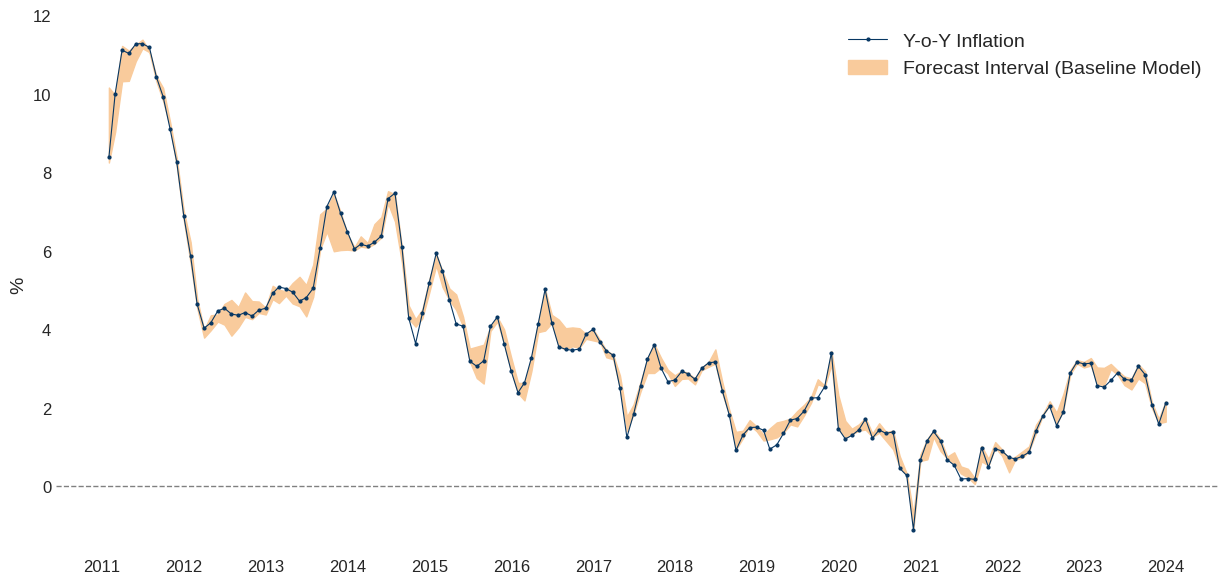

In [34]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(15, 7))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(inflation_obs_pred.index, inflation_obs_pred["cpi"], label="Y-o-Y Inflation ", color='#073763', linewidth=0.8, marker='o', markersize=2)
ax.fill_between(inflation_obs_pred.index, inflation_obs_pred["min"], inflation_obs_pred["max"], alpha=1.0, color='#f9cb9c', label="Forecast Interval (Baseline Model)")
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.xaxis.set_major_locator(mdates.YearLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_ylabel("%", fontsize=14)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

fig.savefig('/content/drive/MyDrive/Research/CEMLA 2024/Monthly_Forecast_interval.png', dpi=300, bbox_inches='tight')

<ipython-input-35-3704d282eb16>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


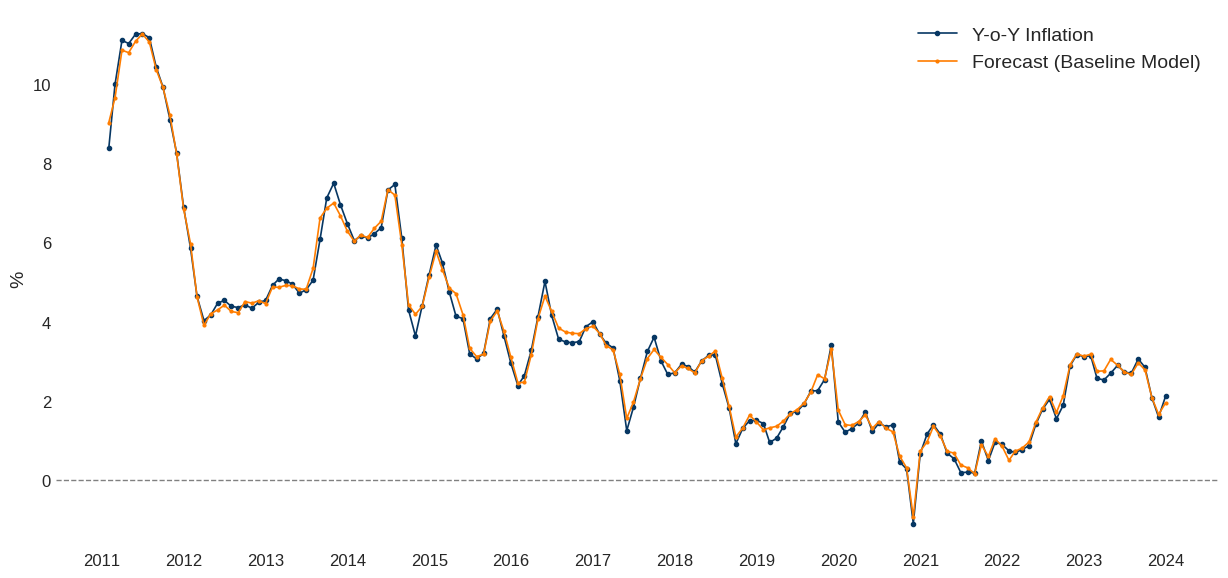

In [35]:
plt.style.use('seaborn-darkgrid')
fig3, ax3 = plt.subplots(figsize=(15, 7))
fig3.patch.set_facecolor('white')
ax3.set_facecolor('white')
ax3.plot(inflation_obs_pred.index, inflation_obs_pred["cpi"], label="Y-o-Y Inflation", color='#073763', linewidth=1.2, marker='o', markersize=3)
ax3.plot(inflation_obs_pred.index, inflation_obs_pred["w_avg_best"], label="Forecast (Baseline Model)", color='#ff7d00', linewidth=1.2, marker='o', markersize=2)
ax3.axhline(0, color='gray', linestyle='--', linewidth=1)
ax3.xaxis.set_major_locator(mdates.YearLocator())
#ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax3.set_ylabel("%", fontsize=14)
ax3.legend(fontsize=14)
ax3.tick_params(axis='both', which='major', labelsize=12)
plt.show()

fig3.savefig('/content/drive/MyDrive/Research/CEMLA 2024/Monthly_Forecast.png', dpi=300, bbox_inches='tight')

## **5. Weekly Results**

In [ ]:
test_pred = pd.DataFrame(
    {'cpi': y_test,
     'ridge': ridge_test_pred,
     'lasso': lasso_test_pred,
     'enet': enet_test_pred,
     'ada': ada_test_pred,
     'gbr': gbr_test_pred,
     'rf': rf_test_pred,
     'et': et_test_pred
    }
)

In [ ]:
cpi_test = pd.DataFrame(
    {'cpi': dataset_w['ipc_nal'],
     'ridge': dataset_w['ipc_nal'],
     'lasso': dataset_w['ipc_nal'],
     'enet': dataset_w['ipc_nal'],
     'ada': dataset_w['ipc_nal'],
     'gbr': dataset_w['ipc_nal'],
     'rf': dataset_w['ipc_nal'],
     'et': dataset_w['ipc_nal'],
     'avg': np.nan,
     'w_avg': np.nan,
     'w_avg_best': np.nan,
     'gw_avg': np.nan,
     'gw_avg_best': np.nan,
     'set': np.nan}, index=dataset_w.index
)

cpi_test.loc['2019-01-06':'2023-12-31', 'ridge'] = test_pred['ridge'] * train.std()[0] + train.mean()[0]
cpi_test.loc['2019-01-06':'2023-12-31', 'lasso'] = test_pred['lasso'] * train.std()[0] + train.mean()[0]
cpi_test.loc['2019-01-06':'2023-12-31', 'enet'] = test_pred['enet'] * train.std()[0] + train.mean()[0]
cpi_test.loc['2019-01-06':'2023-12-31', 'ada'] = test_pred['ada'] * train.std()[0] + train.mean()[0]
cpi_test.loc['2019-01-06':'2023-12-31', 'gbr'] = test_pred['gbr'] * train.std()[0] + train.mean()[0]
cpi_test.loc['2019-01-06':'2023-12-31', 'rf'] = test_pred['rf'] * train.std()[0] + train.mean()[0]
cpi_test.loc['2019-01-06':'2023-12-31', 'et'] = test_pred['et'] * train.std()[0] + train.mean()[0]

cpi_test['avg'] = (cpi_test['ridge']+cpi_test['lasso']+cpi_test['enet']+cpi_test['ada']+cpi_test['gbr']+cpi_test['rf']+cpi_test['et']) / 7

inv1 = (1/mse_val_ridge)  / 1000
inv2 = (1/mse_val_lasso) / 1000
inv3 = (1/mse_val_enet) / 1000
inv5 = (1/mse_val_ada) / 1000
inv6 = (1/mse_val_gbr) / 1000
inv7 = (1/mse_val_rf) / 1000
inv8 = (1/mse_val_et) / 1000

num_1 = (cpi_test['ridge'] * inv1) + (cpi_test['lasso'] * inv2) + (cpi_test['enet'] * inv3) + (cpi_test['ada'] * inv5) + (cpi_test['gbr'] * inv6) + (cpi_test['rf'] * inv7) + (cpi_test['et'] * inv8)
den_1 = inv1+inv2+inv3+inv5+inv6+inv7+inv8
cpi_test['w_avg'] = num_1 / den_1

num_2 = (cpi_test['ridge'] * inv1) + (cpi_test['rf'] * inv7) + (cpi_test['et'] * inv8)
den_2 = inv1+inv7+inv8
cpi_test['w_avg_best'] = num_2 / den_2

prod_1 = (cpi_test['ridge']**inv1) * (cpi_test['lasso']**inv2) * (cpi_test['enet']**inv3) * (cpi_test['ada']**inv5) * (cpi_test['gbr']**inv6) * (cpi_test['rf']**inv7) * (cpi_test['et']**inv8)
pow_1 = 1 / (inv1+inv2+inv3+inv5+inv6+inv7+inv8)
cpi_test['gw_avg'] = prod_1**pow_1

prod_2 = (cpi_test['ridge']**inv1) * (cpi_test['rf']**inv7) * (cpi_test['et']**inv8)
pow_2 = 1 / (inv1+inv7+inv8)
cpi_test['gw_avg_best'] = prod_2**pow_2

cpi_test.loc['2019-01-06':'2023-12-31', 'set'] = all_month_pred['set']

In [ ]:
#cpi_test.to_excel('/content/drive/MyDrive/Research/CEMLA 2024/cpi_test_ALL_VARS.xlsx')

In [ ]:
weekly_forecast = pd.read_excel('/content/drive/MyDrive/Research/CEMLA 2024/WEEKLY_INFLATION_FORECAST_ALL_VARS.xlsx',
                                index_col=0,
                                sheet_name='y-o-y inflation')

weekly_forecast['min'] = weekly_forecast[best_alg].min(axis=1)
weekly_forecast['max'] = weekly_forecast[best_alg].max(axis=1)
weekly_forecast.loc[weekly_forecast['set'].isna(), 'cpi'] = np.nan

In [ ]:
weekly_forecast

,cpi,ridge,lasso,enet,ada,gbr,rf,et,avg,w_avg,w_avg_best,gw_avg,gw_avg_best,set,min,max
date,,,,,,,,,,,,,,,,
2019-01-06,NaN,1.250324,0.800511,1.256855,1.251225,1.392261,1.351006,1.393825,1.242287,1.325921,1.352507,1.325879,1.352486,NaN,1.250324,1.393825
2019-01-13,NaN,1.103694,0.800511,1.136950,1.251225,1.332035,1.360167,1.413666,1.199750,1.287564,1.303468,1.287478,1.303384,NaN,1.103694,1.413666
2019-01-20,NaN,0.972935,0.800511,0.564221,1.272641,1.268799,1.289245,1.369902,1.076893,1.188954,1.229697,1.188695,1.229559,NaN,0.972935,1.369902
2019-01-27,NaN,1.175624,0.800511,0.795262,1.322611,1.267550,1.218729,1.343448,1.131962,1.227894,1.275299,1.227784,1.275275,NaN,1.175624,1.343448
2019-01-31,1.427647,1.167408,0.800511,0.979829,1.289298,1.261551,1.279634,1.322966,1.157314,1.240001,1.262190,1.239944,1.262169,validation,1.167408,1.322966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-03,NaN,1.622183,0.331983,1.044933,1.580456,1.870525,1.382566,1.794177,1.375260,1.605198,1.765594,1.604805,1.765549,NaN,1.382566,1.794177
2023-12-10,NaN,1.880797,0.331983,1.437531,1.746509,2.018666,1.456322,1.978182,1.549999,1.788119,1.961263,1.787710,1.961249,NaN,1.456322,1.978182
2023-12-17,NaN,1.747441,0.331983,1.339993,1.853042,1.998551,1.552660,2.028804,1.550353,1.795377,1.940514,1.794968,1.940440,NaN,1.552660,2.028804


<ipython-input-38-b8fc90bc9cd2>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


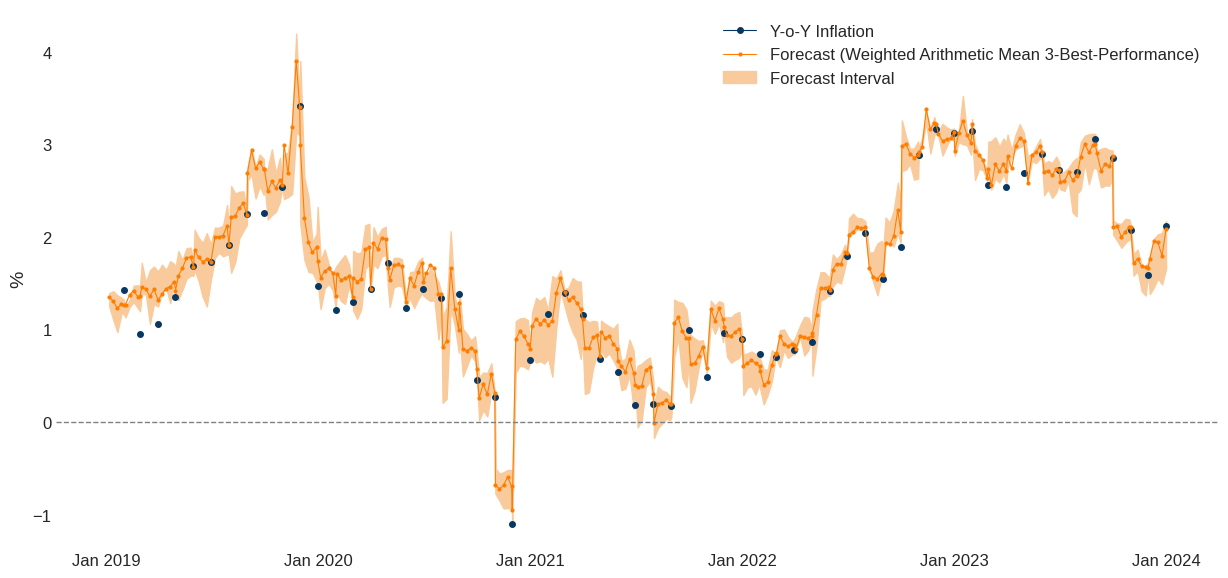

In [ ]:
plt.style.use('seaborn-darkgrid')
fig4, ax = plt.subplots(figsize=(15, 7))
fig4.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(weekly_forecast.index, weekly_forecast["cpi"], label="Y-o-Y Inflation ", color='#073763', linewidth=0.8, marker='o', markersize=4)
ax.plot(weekly_forecast.index, weekly_forecast["w_avg_best"], label="Forecast (Weighted Arithmetic Mean 3-Best-Performance) ", color='#ff7d00', linewidth=0.8, marker='o', markersize=2)
ax.fill_between(weekly_forecast.index, weekly_forecast["min"], weekly_forecast["max"], alpha=1.0, color='#f9cb9c', label="Forecast Interval")
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_ylabel("%", fontsize=14)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

#fig4.savefig('/content/drive/MyDrive/Research/CEMLA 2024/Weekly_Forecast.png', dpi=300, bbox_inches='tight')

## **6. Feature Importance**

In [ ]:
feat_importance = feature_importance_ridge.merge(feature_importance_lasso, left_on='feat', right_on='feat', how='inner')
feat_importance = feat_importance.merge(feature_importance_enet, left_on='feat', right_on='feat', how='inner')
feat_importance = feat_importance.merge(feature_importance_ada, left_on='feat', right_on='feat', how='inner')
feat_importance = feat_importance.merge(feature_importance_gbr, left_on='feat', right_on='feat', how='inner')
feat_importance = feat_importance.merge(feature_importance_rf, left_on='feat', right_on='feat', how='inner')
feat_importance = feat_importance.merge(feature_importance_et, left_on='feat', right_on='feat', how='inner')

num_f = (feat_importance['imp_ridge'] * inv1) + (feat_importance['imp_lasso'] * inv2) + (feat_importance['imp_enet'] * inv3) + (feat_importance['imp_ada'] * inv5) + (feat_importance['imp_gbr'] * inv6) + (feat_importance['imp_rf'] * inv7) + (feat_importance['imp_et'] * inv8)
den_f = inv1+inv2+inv3+inv5+inv6+inv7+inv8
feat_importance['w_avg'] = num_f / den_f

feat_importance.sort_values(['w_avg'], ascending=False, inplace=True)
feat_importance.head(15)

,feat,imp_ridge,imp_lasso,imp_enet,imp_ada,imp_gbr,imp_rf,imp_et,w_avg
0,ipc_nal_l1,1.761894e-01,0.899295,0.085091,0.069771,0.244348,0.122598,0.092313,0.148659
2,ufv,1.170031e-01,0.000000,0.078308,0.061322,0.163475,0.128274,0.087092,0.107866
4,ipc_nal_l6,1.146263e-01,0.000053,0.077875,0.065241,0.129661,0.085552,0.098210,0.097893
1,ipc_nal_l2,1.436517e-01,0.000000,0.082577,0.054186,0.103521,0.140342,0.054514,0.094863
5,ipc_nal_l12,1.054082e-01,0.000000,0.074727,0.083600,0.073505,0.075440,0.076132,0.080324
3,ipc_nal_l3,1.166634e-01,0.000000,0.080204,0.042878,0.057125,0.096306,0.047292,0.071125
27,flour_tj,6.357094e-03,0.000000,0.000000,0.023632,0.099769,0.083533,0.060768,0.052191
78,ycorn_ea,0.000000e+00,0.000000,0.000000,0.041061,0.045724,0.061164,0.068005,0.041871
9,milk_po,1.903127e-02,0.000000,0.018352,0.020683,0.000413,0.003172,0.045864,0.020592
46,milk_bol,8.408074e-06,0.000000,0.009703,0.044811,0.010039,0.012194,0.038581,0.020130


In [ ]:
#feat_importance.to_excel('/content/drive/MyDrive/Research/CEMLA 2024/FEAT_IMPORTANCE_ALL_VARS.xlsx')

## **7. ARIMA**

In [ ]:
#!pip install pmdarima   # install the library

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.9 MB/s eta 0:00:00


In [ ]:
cpi_hist = pd.read_excel('/content/drive/MyDrive/Research/CEMLA 2024/CPI_historic.xlsx', index_col=0)
inf_hist = cpi_hist.pct_change(12).dropna(axis=0)
inf_hist

,ipc
mes,
1991-01-01,0.236074
1991-02-01,0.240554
1991-03-01,0.244090
1991-04-01,0.246137
1991-05-01,0.249048
...,...
2023-10-01,0.020754
2023-11-01,0.015941
2023-12-01,0.021183


In [ ]:
#from pmdarima.arima import auto_arima

# Fit an auto ARIMA model to the variable
#model_1 = auto_arima(inf_hist.loc[:'2011-09-01', 'ipc'], seasonal=True, m=12)
#model_2 = auto_arima(inf_hist.loc[:'2011-12-01', 'ipc'], seasonal=True, m=12)
#model_3 = auto_arima(inf_hist.loc[:'2012-03-01', 'ipc'], seasonal=True, m=12)
#model_4 = auto_arima(inf_hist.loc[:'2012-06-01', 'ipc'], seasonal=True, m=12)
#model_5 = auto_arima(inf_hist.loc[:'2012-07-01', 'ipc'], seasonal=True, m=12)
#model_6 = auto_arima(inf_hist.loc[:'2012-12-01', 'ipc'], seasonal=True, m=12)
#model_7 = auto_arima(inf_hist.loc[:'2013-05-01', 'ipc'], seasonal=True, m=12)
#model_8 = auto_arima(inf_hist.loc[:'2013-06-01', 'ipc'], seasonal=True, m=12)
#model_9 = auto_arima(inf_hist.loc[:'2013-07-01', 'ipc'], seasonal=True, m=12)
#model_10 = auto_arima(inf_hist.loc[:'2014-09-01', 'ipc'], seasonal=True, m=12)
#model_11 = auto_arima(inf_hist.loc[:'2015-03-01', 'ipc'], seasonal=True, m=12)
#model_12 = auto_arima(inf_hist.loc[:'2015-07-01', 'ipc'], seasonal=True, m=12)
#model_13 = auto_arima(inf_hist.loc[:'2016-08-01', 'ipc'], seasonal=True, m=12)
#model_14 = auto_arima(inf_hist.loc[:'2016-09-01', 'ipc'], seasonal=True, m=12)
#model_15 = auto_arima(inf_hist.loc[:'2017-04-01', 'ipc'], seasonal=True, m=12)
#model_16 = auto_arima(inf_hist.loc[:'2017-06-01', 'ipc'], seasonal=True, m=12)
#model_17 = auto_arima(inf_hist.loc[:'2017-10-01', 'ipc'], seasonal=True, m=12)
#model_18 = auto_arima(inf_hist.loc[:'2018-06-01', 'ipc'], seasonal=True, m=12)
#model_19 = auto_arima(inf_hist.loc[:'2018-09-01', 'ipc'], seasonal=True, m=12)
#model_20 = auto_arima(inf_hist.loc[:'2018-10-01', 'ipc'], seasonal=True, m=12)
#model_21 = auto_arima(inf_hist.loc[:'2018-12-01', 'ipc'], seasonal=True, m=12)
#model_22 = auto_arima(inf_hist.loc[:'2019-01-01', 'ipc'], seasonal=True, m=12)
#model_23 = auto_arima(inf_hist.loc[:'2019-02-01', 'ipc'], seasonal=True, m=12)
#model_24 = auto_arima(inf_hist.loc[:'2019-05-01', 'ipc'], seasonal=True, m=12)
#model_25 = auto_arima(inf_hist.loc[:'2019-08-01', 'ipc'], seasonal=True, m=12)
#model_26 = auto_arima(inf_hist.loc[:'2020-06-01', 'ipc'], seasonal=True, m=12)
#model_27 = auto_arima(inf_hist.loc[:'2020-11-01', 'ipc'], seasonal=True, m=12)
#model_28 = auto_arima(inf_hist.loc[:'2021-05-01', 'ipc'], seasonal=True, m=12)
#model_29 = auto_arima(inf_hist.loc[:'2021-12-01', 'ipc'], seasonal=True, m=12)
#model_30 = auto_arima(inf_hist.loc[:'2022-07-01', 'ipc'], seasonal=True, m=12)
#model_31 = auto_arima(inf_hist.loc[:'2023-03-01', 'ipc'], seasonal=True, m=12)
#model_32 = auto_arima(inf_hist.loc[:'2023-08-01', 'ipc'], seasonal=True, m=12)

# Print the model summary
#print(model_32.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  392
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                1408.982
Date:                                 Wed, 17 Apr 2024   AIC                          -2803.963
Time:                                         14:07:32   BIC                          -2776.182
Sample:                                     01-01-1991   HQIC                         -2792.952
                                          - 08-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.000     -2.026      0.043      -0.000    -7.6

In [ ]:
#forecast_validation = inflation_obs_pred[inflation_obs_pred['set']=='validation'].copy()
#forecast_validation['arima'] = np.nan

#forecast_validation['arima'][0] = model_1.predict(n_periods=1).values * 100
#forecast_validation['arima'][1] = model_2.predict(n_periods=1).values * 100
#forecast_validation['arima'][2] = model_3.predict(n_periods=1).values * 100
#forecast_validation['arima'][3] = model_4.predict(n_periods=1).values * 100
#forecast_validation['arima'][4] = model_5.predict(n_periods=1).values * 100
#forecast_validation['arima'][5] = model_6.predict(n_periods=1).values * 100
#forecast_validation['arima'][6] = model_7.predict(n_periods=1).values * 100
#forecast_validation['arima'][7] = model_8.predict(n_periods=1).values * 100
#forecast_validation['arima'][8] = model_9.predict(n_periods=1).values * 100
#forecast_validation['arima'][9] = model_10.predict(n_periods=1).values * 100
#forecast_validation['arima'][10] = model_11.predict(n_periods=1).values * 100
#forecast_validation['arima'][11] = model_12.predict(n_periods=1).values * 100
#forecast_validation['arima'][12] = model_13.predict(n_periods=1).values * 100
#forecast_validation['arima'][13] = model_14.predict(n_periods=1).values * 100
#forecast_validation['arima'][14] = model_15.predict(n_periods=1).values * 100
#forecast_validation['arima'][15] = model_16.predict(n_periods=1).values * 100
#forecast_validation['arima'][16] = model_17.predict(n_periods=1).values * 100
#forecast_validation['arima'][17] = model_18.predict(n_periods=1).values * 100
#forecast_validation['arima'][18] = model_19.predict(n_periods=1).values * 100
#forecast_validation['arima'][19] = model_20.predict(n_periods=1).values * 100
#forecast_validation['arima'][20] = model_21.predict(n_periods=1).values * 100
#forecast_validation['arima'][21] = model_22.predict(n_periods=1).values * 100
#forecast_validation['arima'][22] = model_23.predict(n_periods=1).values * 100
#forecast_validation['arima'][23] = model_24.predict(n_periods=1).values * 100
#forecast_validation['arima'][24] = model_25.predict(n_periods=1).values * 100
#forecast_validation['arima'][25] = model_26.predict(n_periods=1).values * 100
#forecast_validation['arima'][26] = model_27.predict(n_periods=1).values * 100
#forecast_validation['arima'][27] = model_28.predict(n_periods=1).values * 100
#forecast_validation['arima'][28] = model_29.predict(n_periods=1).values * 100
#forecast_validation['arima'][29] = model_30.predict(n_periods=1).values * 100
#forecast_validation['arima'][30] = model_31.predict(n_periods=1).values * 100
#forecast_validation['arima'][31] = model_32.predict(n_periods=1).values * 100

#forecast_validation

<ipython-input-66-c3dc3fc6d24e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_validation['arima'][0] = model_1.predict(n_periods=1).values * 100
<ipython-input-66-c3dc3fc6d24e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_validation['arima'][1] = model_2.predict(n_periods=1).values * 100
<ipython-input-66-c3dc3fc6d24e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_validation['arima'][2] = model_3.pr

,cpi,ridge,lasso,enet,ada,gbr,rf,et,avg,w_avg,w_avg_best,gw_avg,gw_avg_best,set,min,max,arima
date,,,,,,,,,,,,,,,,,
2011-10-31,9.11,9.29,11.72,10.02,9.36,9.11,9.23,9.17,9.70,9.31,9.22,9.31,9.22,validation,9.17,9.29,9.287045
2012-01-31,5.86,6.22,8.40,6.92,6.28,5.48,6.21,5.68,6.45,6.03,5.97,6.03,5.97,validation,5.68,6.22,6.220661
2012-04-30,4.17,3.98,6.67,3.85,3.91,4.28,4.36,4.24,4.47,4.20,4.20,4.19,4.20,validation,3.98,4.36,3.907713
2012-07-31,4.39,4.75,6.54,4.36,3.83,3.90,3.84,4.20,4.49,4.20,4.26,4.20,4.26,validation,3.84,4.75,4.561296
2012-08-31,4.36,4.57,6.49,4.37,3.51,4.27,4.05,4.12,4.48,4.21,4.23,4.21,4.23,validation,4.05,4.57,4.548787
2013-01-31,4.92,5.11,6.45,6.10,4.15,4.74,4.84,4.77,5.17,4.90,4.88,4.90,4.88,validation,4.77,5.11,4.732380
2013-06-30,4.81,5.13,6.48,5.47,4.43,4.48,4.33,4.92,5.03,4.80,4.82,4.80,4.82,validation,4.33,5.13,4.926994
2013-07-31,5.05,5.37,6.35,5.25,4.03,4.64,4.83,5.65,5.16,5.10,5.35,5.10,5.35,validation,4.83,5.65,4.913698
2013-08-31,6.08,6.04,6.55,5.74,7.48,7.30,6.72,6.93,6.68,6.76,6.62,6.76,6.62,validation,6.04,6.93,5.224460


In [ ]:
#forecast_validation.to_excel('/content/drive/MyDrive/Research/CEMLA 2024/FORECAST_VALIDATION.xlsx')

In [ ]:
forecast_validation2 = pd.read_excel('/content/drive/MyDrive/Research/CEMLA 2024/FORECAST_VALIDATION.xlsx', index_col=0)

In [ ]:
ML_MSE = mean_squared_error(forecast_validation2['cpi'], forecast_validation2['w_avg_best'], squared=True)
ML_MAE = mean_absolute_error(forecast_validation2['cpi'], forecast_validation2['w_avg_best'])
ML_R2 = r2_score(forecast_validation2['cpi'], forecast_validation2['w_avg_best'])

ARIMA_MSE = mean_squared_error(forecast_validation2['cpi'], forecast_validation2['arima'], squared=True)
ARIMA_MAE = mean_absolute_error(forecast_validation2['cpi'], forecast_validation2['arima'])
ARIMA_R2 = r2_score(forecast_validation2['cpi'], forecast_validation2['arima'])

print("ML MSE: ", ML_MSE)
print("ML MAE: ", ML_MAE)
print("ML R2: ", ML_R2)
print("ARIMA MSE: ", ARIMA_MSE)
print("ARIMA MAE: ", ARIMA_MAE)
print("ARIMA R2: ", ARIMA_R2)

ML MSE:  0.06347500000000003
ML MAE:  0.19437500000000005
ML R2:  0.9828259119718071
ARIMA MSE:  0.10150312901619227
ARIMA MAE:  0.2546768978847054
ARIMA R2:  0.9725368464299157


## End